In [1]:
# Set up packages for lecture. Don't worry about understanding this code, but
# make sure to run it if you're following along.
import numpy as np
import babypandas as bpd
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
from scipy import stats
%reload_ext pandas_tutor
%set_pandas_tutor_options {'projectorMode': True}
set_matplotlib_formats("svg")
plt.style.use('fivethirtyeight')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

from ipywidgets import widgets
from IPython.display import clear_output, display

# All of the following code is for visualization.
def plot_regression_line(df, x, y, margin=.02):
    '''Computes the slope and intercept of the regression line between columns x and y in df (in original units) and plots it.'''
    m = slope(df, x, y)
    b = intercept(df, x, y)
    
    df.plot(kind='scatter', x=x, y=y, s=100, figsize=(10, 5), label='original data')
    left = df.get(x).min()*(1 - margin)
    right = df.get(x).max()*(1 + margin)
    domain = np.linspace(left, right, 10)
    plt.plot(domain, m*domain + b, color='purple', label='regression line')
    plt.suptitle(format_equation(m, b), fontsize=18)
    plt.legend();
    
def format_equation(m, b):
    if b > 0:
        return r'$y = %.2fx + %.2f$' % (m, b)
    elif b == 0:
        return r'$y = %.2fx' % m
    else:
        return r'$y = %.2fx %.2f$' % (m, b)
    
def plot_errors(df, m, b):
    x = df.get('x')
    y = m*x + b
    df.plot(kind='scatter', x='x', y='y', s=100, figsize=(10, 5), label='original data')
    plt.plot(x, y, color='purple', label='regression line')
    for k in np.arange(df.shape[0]):
        xk = df.get('x').iloc[k]
        yk = np.asarray(y)[k]
        if k == df.shape[0] - 1:
            plt.plot([xk, xk], [yk, df.get('y').iloc[k]], '--', c='r', linewidth=2, label='errors')
        else:
            plt.plot([xk, xk], [yk, df.get('y').iloc[k]], '--', c='r', linewidth=2)
    
    plt.suptitle(format_equation(m, b), fontsize=18)
    plt.xlim(50, 90)
    plt.ylim(40, 100)
    plt.legend();
    
def update_plot(w):
    m = slope_widget.value
    b = without_outlier.get('y').mean() - m * without_outlier.get('x').mean()
    with out:
        out.clear_output(wait=True)
        plot_errors(without_outlier, m, b)
        plt.show()

# Lecture 25 – Regression and Least Squares

## DSC 10, Summer 2022

### Announcements

- HW 7 is due on **Saturday at 11:59pm**.
- Lab 8 is due on **Tues at 11:59pm**.
- The Final Project is due on **Wednesday 8/31 at 11:59pm**.

### Final Exam Details

- The Final Exam takes place **Sat, 9/3 from 11:30am-2:30pm**.
- Location: WLH 2207 (same as lecture and midterm).
    - In-person, on-paper.
    - We'll provide the [DSC 10 reference sheet][ref] again. (Don't print it out yourself.)
    - You can bring **two** 8.5x11" double-sided pages of hand-written notes.
- I'll write the exam so that it'll take about 2 hrs so you don't have to feel rushed.
- Practice exams at https://practice.dsc10.com/. Extra exams on DSC 10 Resources page of website.

[ref]: https://drive.google.com/file/d/1mQApk9Ovdi-QVqMgnNcq5dZcWucUKoG-/view

### Agenda

- Prediction.
- The regression line.
- Outliers.
- Errors in prediction.

## Prediction

### Correlation

Recall, the correlation coefficient $r$ of two variables $x$ and $y$ is the 
- **average** value of the 
- **product** of $x$ and $y$
- when both are measured in **standard units**.

### The regression line

Suppose **$x$ and $y$ are in standard units**, and $r$ is the correlation coefficient between $x$ and $y$. Then, the regression line is defined as follows:

<center><img src='data/regression-line.png' width=400></center>

- The regression line is the line through $(0,0)$ with slope $r$.
- If $x$ and $y$ are linearly associated, then the graph of averages will be very similar to the regression line.
- If the regression line is given by $f(x) = mx + b$, then the prediction for $x$ is given by $f(x)$.

### You Try

A course has a midterm (mean 80, standard deviation 15) and a really hard final (mean 50, standard deviation 12).

If the scatter diagram comparing midterm & final scores for students looks linearly associated with correlation 0.75, then what is the predicted final exam score for a student who received a 90 on the midterm?

## The regression line

### The regression line in standard units

When $x$ and $y$ are in standard units, the regression line is given by

$$y_{\text{su}} = r \cdot x_{\text{su}}$$

What is the regression line when $x$ and $y$ are in their original units?

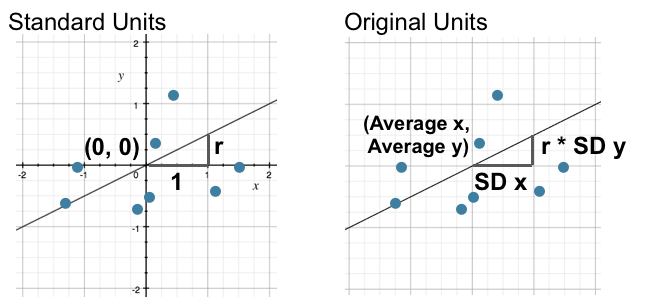

### The regression line in original units

- We can work backwards from the relationship $y_{\text{su}} = r \cdot x_{\text{su}}$ to find the line in original units.

$$y_{\text{su}} = r \cdot x_{\text{su}}$$

$$\frac{y - \text{mean of }y}{\text{SD of }y} = r \cdot \frac{x - \text{mean of } x}{\text{SD of }x}$$

- Note that $\text{mean of } x$, $\text{mean of } y$, $\text{SD of } x$, and $\text{SD of } y$ are constants.
- Re-arranging the above equation into the form $y = mx + b$ yields the formulas

$$m = r \cdot \frac{\text{SD of } y}{\text{SD of }x}, \: \: b = \text{mean of } y - m \cdot \text{mean of } x$$

- $m$ is the slope of the regression line and $b$ is the intercept.

Let's implement these formulas in code and try them out.

### You Try:

For the `galton` dataset, fit a linear model that uses `midparentHeight` to predict `childHeight`.

1. Compute the correlation coefficient.
    - You can use the `standard_units` function below.
1. Compute the slope of the best-fit line as the variable `m_heights`.
1. Compute the intercept of the best-fit line as the variable `b_heights`.

In [2]:
galton = bpd.read_csv('data/galton.csv')
galton

,family,father,mother,midparentHeight,children,childNum,gender,childHeight
0,1,78.5,67.0,75.43,4,1,male,73.2
1,1,78.5,67.0,75.43,4,2,female,69.2
2,1,78.5,67.0,75.43,4,3,female,69.0
...,...,...,...,...,...,...,...,...
931,203,62.0,66.0,66.64,3,3,female,61.0
932,204,62.5,63.0,65.27,2,1,male,66.5
933,204,62.5,63.0,65.27,2,2,female,57.0


In [3]:
def standard_units(any_numbers):
    "Convert a sequence of numbers to standard units."
    return (any_numbers - any_numbers.mean()) / np.std(any_numbers)

In [4]:
r = (standard_units(galton.get('midparentHeight')) *
     standard_units(galton.get('childHeight'))).mean()
r

0.320949896063959

In [5]:
m_heights = (r * np.std(galton.get('childHeight')) /
             np.std(galton.get('midparentHeight')))
m_heights

0.6373608969694784

In [6]:
b_heights = (galton.get('childHeight').mean() -
             m_heights * galton.get('midparentHeight').mean())

In [7]:
[m_heights, b_heights]

[0.6373608969694784, 22.636240549589765]

### Making functions

In [8]:
def correlation(df, x, y):
    '''Computes the correlation between column x and column y of df.'''
    return (standard_units(df.get(x)) * standard_units(df.get(y))).mean()

def slope(df, x, y):
    '''Returns the slope of the regression line between columns x and y in df (in original units).'''
    r = correlation(df, x, y)
    return r * np.std(df.get(y)) / np.std(df.get(x))

def intercept(df, x, y):
    '''Returns the intercept of the regression line between columns x and y in df (in original units).'''
    return df.get(y).mean() - slope(df, x, y) * df.get(x).mean()

In [9]:
m_height = slope(galton, 'midparentHeight', 'childHeight')
b_height = intercept(galton, 'midparentHeight', 'childHeight')
[m_heights, b_heights]

[0.6373608969694784, 22.636240549589765]

### Making predictions

In [10]:
def predict_child_height(midparent):
    return m_heights * midparent + b_heights

What's the predicted height of a child whose midparent height is 62 inches?

In [11]:
predict_child_height(62)

62.15261616169742

What about for a child whose midparent height is 55 inches? 73 inches?

In [12]:
predict_child_height(55)

57.69108988291108

In [13]:
predict_child_height(73)

69.16358602836169

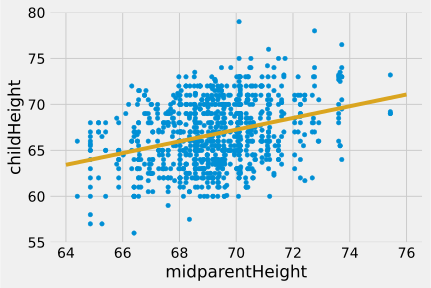

In [14]:
xs = np.arange(64, 77)
ys = predict_child_height(xs)
galton.plot(kind='scatter', x='midparentHeight', y='childHeight');
plt.plot(xs, ys, color='goldenrod');

## Outliers

### The effect of outliers on correlation

Consider the dataset below. What is the correlation between $x$ and $y$?

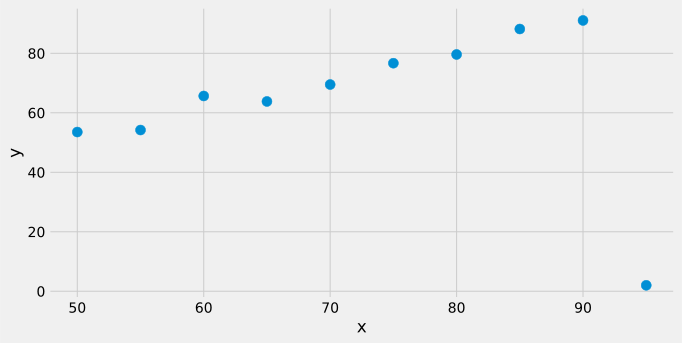

In [15]:
outlier = bpd.read_csv('data/outlier.csv')
outlier.plot(kind='scatter', x='x', y='y', s=100, figsize=(10, 5));

In [16]:
correlation(outlier, 'x', 'y')

-0.02793982443854457

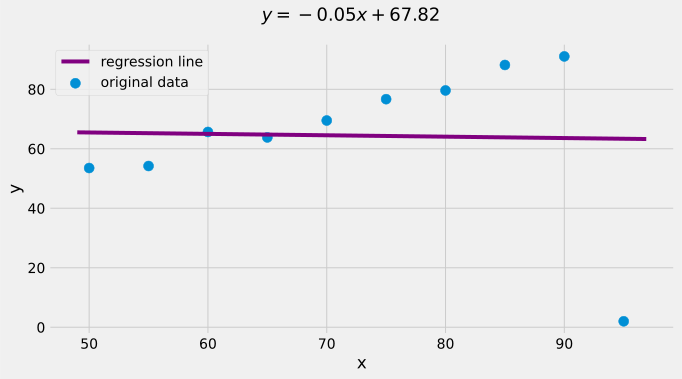

In [17]:
plot_regression_line(outlier, 'x', 'y')

### Removing the outlier

In [18]:
without_outlier = outlier[outlier.get('y') > 40]

In [19]:
correlation(without_outlier, 'x', 'y')

0.9851437295364016

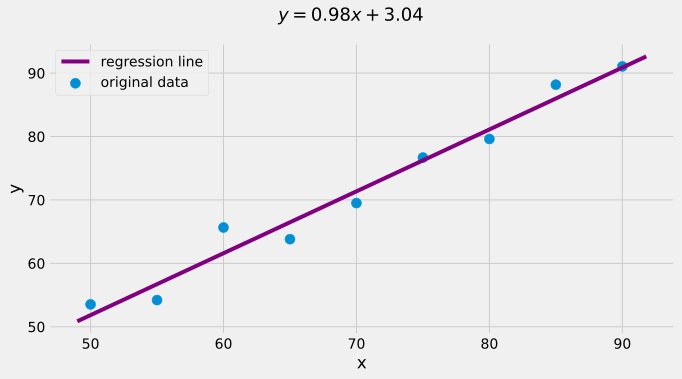

In [20]:
plot_regression_line(without_outlier, 'x', 'y')

**Takeaway:** Even a single outlier can have a massive impact on the correlation, and hence the regression line. Look for these before performing regression.

## Errors in prediction

### Errors in prediction

- We stated that the regression line in standard units is $y_{\text{su}} = r \cdot x_{\text{su}}$, and used that to find a formula for the regression line in original units.
- The regression lines we've seen so far seem like they fit our data well, but how well? What makes them good?

### Without the outlier

In [21]:
m_no_outlier = slope(without_outlier, 'x', 'y')
b_no_outlier = intercept(without_outlier, 'x', 'y')

m_no_outlier, b_no_outlier

(0.975927715724588, 3.042337135297444)

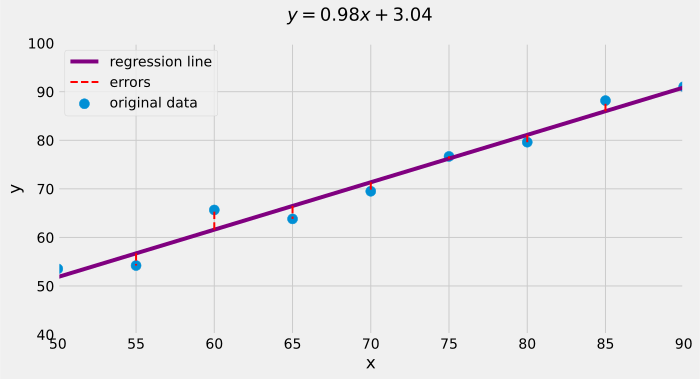

In [22]:
plot_errors(without_outlier, m_no_outlier, b_no_outlier)

### Measuring the error in prediction

$$\text{error} = \text{actual value} - \text{prediction}$$

- Typically, some errors are positive and some negative.
    - What does a positive error mean? What about a negative error?
- To measure the rough size of the errors:
    1. Square the errors so that they don't cancel each other out.
    2. Take the mean of the squared errors.
    3. Take the square root to fix the units.
- This is called **root mean square error** (RMSE).
    - Notice the similarities to computing the SD!

### Root mean squared error (RMSE)

In [23]:
predictions = without_outlier.assign(pred=m_no_outlier * without_outlier.get('x') + b_no_outlier)
predictions = predictions.assign(diffs=predictions.get('y') - predictions.get('pred'))
predictions = predictions.assign(sq_diffs=predictions.get('diffs') ** 2)
predictions

,x,y,pred,diffs,sq_diffs
0,50,53.53,51.84,1.69,2.86
1,55,54.21,56.72,-2.51,6.31
2,60,65.65,61.60,4.06,16.45
...,...,...,...,...,...
6,80,79.61,81.12,-1.51,2.27
7,85,88.17,86.00,2.18,4.74
8,90,91.05,90.88,0.18,0.03


In [24]:
np.sqrt(predictions.get('sq_diffs').mean())

2.19630831647554

### Root mean squared error (RMSE)

In [25]:
def rmse(true, pred):
    '''Calculates the RMSE for two sequences:
    true: the true values of the predicted attribute (i.e. y)
    pred: the predicted values
    '''
    return np.sqrt(((true - pred) ** 2).mean())

In [26]:
rmse(predictions.get('y'), m_no_outlier * predictions.get('x') + b_no_outlier)

2.19630831647554

- Interpret this similar to SD:
    - Majority of points lie within 2.2 units of the regression line.

### Why do we say "least-squares" best fit?

- Idea: The best-fit line is the line that has the least (squared) error.

### You Try:

Try to manually find the best slope and intercept to predict `y` using `x` in the `without_outlier` dataframe.

1. Set `m` and `b` to your guess for the slope and intercept.
1. Find the predictions using your `m` and `b`.
1. Find the RMSE using your `m` and `b`.
1. Repeat steps 1-3 until you can't decrease the RMSE anymore.

In [27]:
without_outlier

,x,y
0,50,53.53
1,55,54.21
2,60,65.65
...,...,...
6,80,79.61
7,85,88.17
8,90,91.05


In [28]:
m = ...
b = ...

In [29]:
# Make predictions, then find the RMSE


In [30]:
# Call this cell to visualize your slope and intercept.
plot_errors(without_outlier, m, b)

TypeError: unsupported operand type(s) for *: 'ellipsis' and 'int'

### Who found the slope/intercept pair with the lowest RMSE?

In [ ]:
m_smallest_rmse = ...
m_smallest_rmse

In [ ]:
b_smallest_rmse = ...
b_smallest_rmse

### Coincidence?

In [ ]:
# The slope and intercept with the smallest RMSE from the class
m_smallest_rmse, b_smallest_rmse

In [ ]:
# The slope and intercept according to our regression line formulas
slope(without_outlier, 'x', 'y'), intercept(without_outlier, 'x', 'y')

The slopes and intercepts we got using both approaches look pretty similar... 👀

### The regression line

- It turns out that the regression line we defined before before minimizes the root mean squared error (RMSE) among all lines.

$$m = r \cdot \frac{\text{SD of } y}{\text{SD of }x}$$

$$b = \text{mean of } y - m \cdot \text{mean of } x$$
  
- It is the **best** line, regardless of what our data looks like!
- All equivalent names:
    - Line of “best fit”.
    - Least squares line.
    - Regression line.
    - Simple linear model.
- The technique of finding the slope and intercept that have the lowest RMSE is called the **method of least squares**.

### Quality of fit

- The regression line describes the "best linear fit" for a given dataset.
- The formulas for the slope and intercept work no matter what the shape of the data is.
- But the line is only meaningful if the relationship between $x$ and $y$ is roughly linear.

### Example: non-linear data

What's the regression line for this dataset?

In [ ]:
np.random.seed(23)
x2 = bpd.DataFrame().assign(
    x=np.arange(-6, 6.1, 0.5) + np.random.normal(size=25), 
    y=np.arange(-6, 6.1, 0.5)**2 + np.random.normal(size=25)
)
x2.plot(kind='scatter', x='x', y='y', s=100, figsize=(10, 5));

In [ ]:
plot_regression_line(x2, 'x', 'y')

This line doesn't fit the data at all!

## Why does it matter?

- Now, you can fit linear models!
- The idea of least-squares is very useful.
    - If we swap out RMSE with other kinds of errors, we can change our model.
    - You'll see this idea over and over again in machine learning.
- **Next time:** The regression line is the best *line* to fit the data, but not all data is linear. How do we determine whether fitting a line even makes sense for our dataset?